In [19]:
import numpy as np
import os
import pandas as pd
import soundfile as sf

import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib.patches import Rectangle

import scipy.io.wavfile as wav
import datetime as dt
from pathlib import Path

from torch import multiprocessing
from tqdm import tqdm

In [2]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

In [3]:
from src.cfg import get_config
from src.pipeline import pipeline

In [4]:
def subsample(percent_on, audio):
    # Calculate time on for duty cycle using percent on
    samples_on = percent_on*audio.shape[0]
    sub_audio = audio[:np.ceil(samples_on).astype('int32')]

    return np.arange(samples_on), sub_audio.astype('int16')

def subsample_frompath(percent_on, audio_filepath, output_dir):

    audio = sf.SoundFile(audio_filepath)

    sr = audio.samplerate
    audio_length = audio.frames 
    frames_on = percent_on * audio_length
    
    sub_audio = audio.read(np.round(frames_on).astype('int32'), dtype='int16')

    op_file = os.path.basename(audio_filepath.name).replace(" ", "_")
    op_file_en = "__{:.2f}".format(100*percent_on) + "p"
    op_file = op_file[:-4] + op_file_en + ".WAV"

    sf.write(os.path.join(output_dir, op_file), sub_audio, sr, subtype='PCM_16') 

    return sr, sub_audio

def plt_msds(filename, audio, fs, reftimes, times, p_on=1):
    ## Make sure given times are within audio file
    #  If times extend beyond file, reduce times to file boundaries
    times[times < 0] = 0
    times[times > len(audio)/fs] = int(len(audio)/fs)
    audio = audio[times[0]*fs:times[1]*fs]

    ## Strip the datetime for year, month, date, and hour from filename
    file_dt = dt.datetime.strptime(filename, '%Y%m%d_%H%M%S.WAV')

    ## Only find numPoints amount of labels from all available seconds
    numPoints = 11
    seconds = np.arange(fs*times[0], fs*times[1]+1)/fs
    idx = np.round(np.linspace(0, len(seconds)-1, numPoints)).astype('int32')
    sec_labels = reftimes[0] + seconds[idx]

    ## Calculate Time Labels for X-Axis using Datetime objects as Strings
    time_labels = np.array([dt.datetime(year=file_dt.year, month=file_dt.month, 
                                        day=file_dt.day, hour=file_dt.hour, 
                                        minute=file_dt.minute + int(sec/60), second=int(sec%60), 
                                        microsecond=np.round(1e6*(sec%60-int(sec%60))).astype('int32')).strftime('%T.%f')[:-4] 
                                        for sec in sec_labels])

    ## Find x-axis tick locations from all available seconds and convert to samples
    s_ticks = seconds[idx]-times[0]
    x_ticks = s_ticks*fs

    ## Calculate detection parameters from msds output to use for drawing rectangles
    xs_inds, xs_freqs, x_durations, x_bandwidths, det_labels = get_msds_params(filename, reftimes+times)

    ## Create figure
    plt.figure(figsize=(12, 9))

    ## Plotting Audio Signal
    plt.subplot(311)
    plt.title(f"{100*p_on}% Duty Cycle")
    plt.plot(audio)
    plt.ylabel("Amplitude (kU)")
    plt.xlim((0, s_ticks[-1]*fs))
    plt.xticks(ticks=x_ticks, labels=time_labels)
    amp_ticks = plt.yticks()[0]
    amp_ticks = np.insert(amp_ticks, 0, -1*amp_ticks[-1])
    plt.yticks(ticks=amp_ticks, labels=(amp_ticks/1000).astype('int16'))
    plt.ylim((amp_ticks[0], amp_ticks[-1]))
    plt.grid(which="both")

    ## Plotting Spectrogram of Audio Signal
    plt.subplot(312)
    plt.specgram(audio, Fs=fs, cmap='ocean')
    plt.ylabel("Frequency (kHz)")
    plt.xticks(ticks=s_ticks, labels=time_labels)
    ## Find y-axis tick locations from specgram-calculated locations and keep limit just in case
    f_ticks = plt.yticks()[0]
    f_ticks = f_ticks[f_ticks <= fs/2]
    plt.yticks(ticks=f_ticks, labels=(f_ticks/1000).astype('int16'))

    ## Plotting Spectrogram with MSDS outputs overlayed
    plt.subplot(313)
    plt.specgram(audio, Fs=fs, cmap='ocean')
    plt.xlabel("Time (HH:MM:SS)")
    plt.ylabel("Frequency (kHz)")
    plt.xticks(ticks=s_ticks, labels=time_labels)
    plt.yticks(ticks=f_ticks, labels=(f_ticks/1000).astype('int16'))
    ax = plt.gca()
    for i in range(len(xs_inds)):
        rect = Rectangle((xs_inds[i], xs_freqs[i]), 
                        x_durations[i], x_bandwidths[i], 
                        linewidth=1, edgecolor='y', facecolor='none')
        if (np.floor((xs_inds[i]+x_durations[i])*fs).astype('int32') < len(audio) and audio[np.floor((xs_inds[i]+x_durations[i])*fs).astype('int32')] != 0):
            ax.add_patch(rect)
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

def get_msds_params(filename, times):
    csv_file = f'../output_dir/BatDetectorMSDS-{filename}.csv'
    df = pd.read_csv(csv_file)
    s_times = df['start_time']
    e_times = df['end_time']
    s_freqs = df['low_freq']
    e_freqs = df['high_freq']
    det_labels = df['event'].values
    xs_inds = s_times[np.logical_and(s_times > times[0], e_times < times[1])].values - times[0]
    xe_inds = e_times[np.logical_and(s_times > times[0], e_times < times[1])].values - times[0]
    xs_freqs = s_freqs[np.logical_and(s_times > times[0], e_times < times[1])].values
    xe_freqs = e_freqs[np.logical_and(s_times > times[0], e_times < times[1])].values
    x_durations = xe_inds - xs_inds
    x_bandwidths = xe_freqs - xs_freqs

    return xs_inds, xs_freqs, x_durations, x_bandwidths, det_labels

In [9]:
## No Subsampling, Raw First 10 min of Audio File

filepath = f"{Path.home()}/Downloads"
filename = "20210910_030000.WAV"

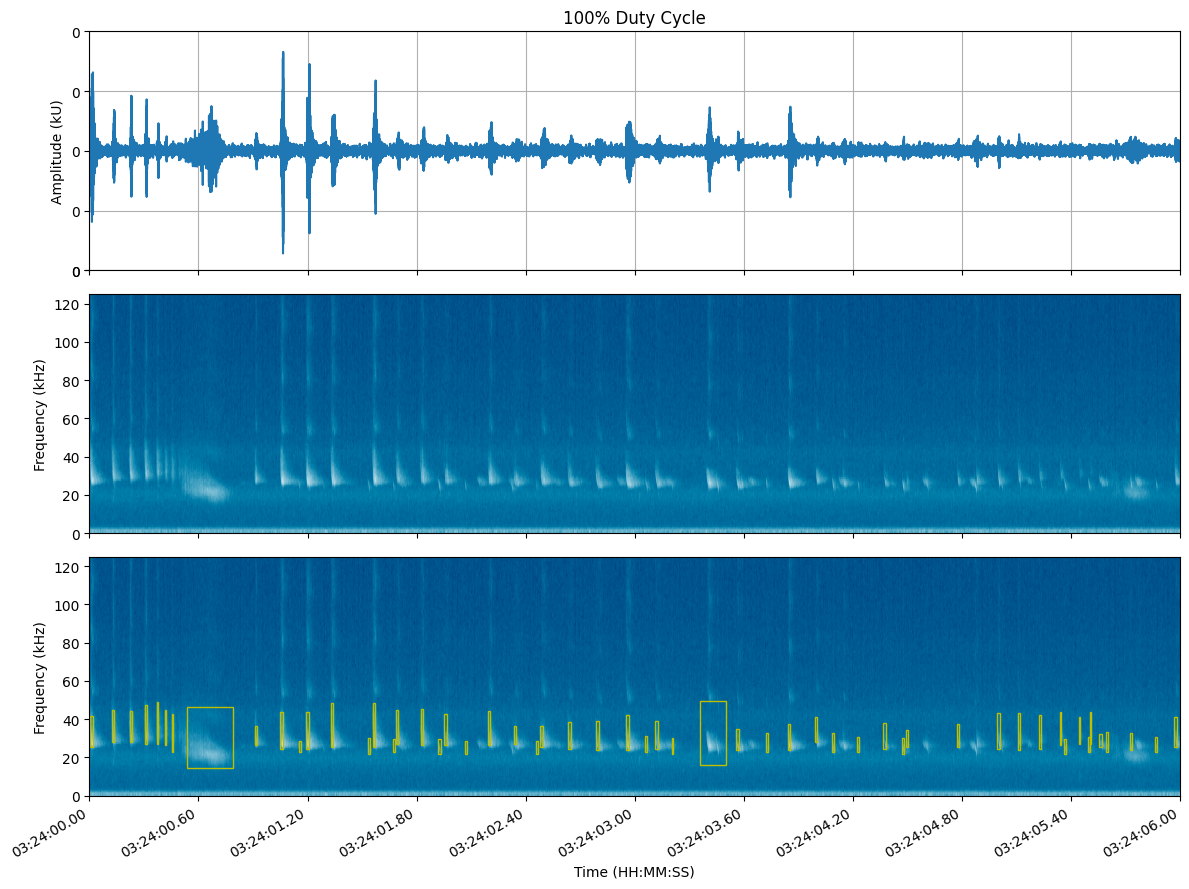

In [64]:
track = sf.SoundFile(Path(f'{filepath}/{filename}'))

can_seek = track.seekable() # True
if not can_seek:
    raise ValueError("Not compatible with seeking")

sr = track.samplerate
reftimes = np.array([1440, 1500])

start_frame = sr * reftimes[0]
frames_to_read = sr * (reftimes[1] - reftimes[0])
track.seek(start_frame)
audio_section = track.read(frames_to_read)

times = np.array([0, 6]) # seconds from beginning of audio

plt_msds(filename, audio_section, sr, reftimes, times)

In [16]:
args = dict()
args["input_audio"] = f'{filepath}/{filename}'
args["output_directory"] = f'../output_dir/'
args["tmp_directory"] = f'../output/tmp'
args["csv"] = True
args["num_processes"] = 4

cfg = get_config()
cfg["should_csv"] = args["csv"]
cfg["output_dir"] = Path(args["output_directory"])
cfg["tmp_dir"] = Path(args["tmp_directory"])
cfg["audio_file"] = Path(args["input_audio"])
cfg["num_processes"] = args["num_processes"]
cfg

{'time_expansion_factor': 1.0,
 'start_time': 0.0,
 'segment_duration': 30.0,
 'models': [<models.bat_call_detector.model_detector.BatCallDetector at 0x16be354f0>],
 'should_csv': True,
 'output_dir': PosixPath('../output_dir'),
 'tmp_dir': PosixPath('../output/tmp'),
 'audio_file': PosixPath('/Users/adityakrishna/Downloads/20210910_030000.WAV'),
 'num_processes': 4}

In [17]:
def generate_segments(audio_file: Path, output_dir: Path, start_time: float, duration: float):
    """
    Segments audio_file into clips of duration length and saves them to output_dir.
    start_time: seconds
    duration: seconds
    """

    ip_audio = sf.SoundFile(audio_file)

    sampling_rate = ip_audio.samplerate
    # Convert to sampled units
    ip_start = int(start_time * sampling_rate)
    ip_duration = int(duration * sampling_rate)
    ip_end = ip_audio.frames

    output_files = []

    # for the length of the duration, process the audio into duration length clips
    for sub_start in range(ip_start, ip_end, ip_duration):
        sub_end = np.minimum(sub_start + ip_duration, ip_end)

        sub_length = sub_end - sub_start
        ip_audio.seek(sub_start)
        op_audio = ip_audio.read(sub_length)

        # For file names, convert back to seconds 
        op_file = os.path.basename(audio_file.name).replace(" ", "_")
        start_seconds = sub_start / sampling_rate
        end_seconds = sub_end / sampling_rate
        op_file_en = "__{:.2f}".format(start_seconds) + "_" + "{:.2f}".format(end_seconds)
        op_file = op_file[:-4] + op_file_en + ".wav"
        
        op_path = os.path.join(output_dir, op_file)
        output_files.append({
            "audio_file": op_path, 
            "offset": start_time + (sub_start/sampling_rate),
        })
                
        # TODO: ensure 16 bitdepth is correct
        # TODO: maybe make this configurable parameter?
        sf.write(op_path, op_audio, sampling_rate, subtype='PCM_16') 

    return output_files 

In [14]:
## Generate subsamples

def generate_subsamples(input_filepath, output_dirpath, rangeofcycles):
    for p_on in rangeofcycles:
        sample_rate, sub_audio = subsample_frompath(percent_on = p_on, 
                                                    audio_filepath = input_filepath, 
                                                    output_dir = output_dirpath)
        

In [85]:
cfg["audio_file"] = Path('../input_dir/20210910_030000__5.00p.WAV')

segmented_file_paths = generate_segments(
        audio_file = cfg['audio_file'], 
        output_dir = cfg['tmp_dir'],
        start_time = cfg['start_time'],
        duration   = cfg['segment_duration'],
    )

segmented_file_paths

[{'audio_file': '../output/tmp/20210910_030000__5.00p__0.00_30.00.wav',
  'offset': 0.0},
 {'audio_file': '../output/tmp/20210910_030000__5.00p__30.00_60.00.wav',
  'offset': 30.0},
 {'audio_file': '../output/tmp/20210910_030000__5.00p__60.00_89.75.wav',
  'offset': 60.0}]

In [86]:
pipeline._apply_models(cfg, segmented_file_paths)

Applying BatDetectorMSDS: 100%|██████████| 3/3 [00:32<00:00, 10.99s/it]


[PosixPath('../output_dir/BatDetectorMSDS-20210910_030000__5.00p.WAV.csv')]

In [87]:
cfg["audio_file"] = Path('../input_dir/20210910_030000__85.00p.WAV')

segmented_file_paths = generate_segments(
        audio_file = cfg['audio_file'], 
        output_dir = cfg['tmp_dir'],
        start_time = cfg['start_time'],
        duration   = cfg['segment_duration'],
    )

segmented_file_paths

csv_names = []
audio_file_path = cfg['audio_file']
process_pool = multiprocessing.Pool(cfg['num_processes'])

l_for_mapping = [{
    'audio_seg': audio_seg, 
    'model': cfg['models'][0],
    'original_file_name': audio_file_path,
    } for audio_seg in segmented_file_paths]

cur_seg = l_for_mapping[-3]
cur_seg

{'audio_seg': {'audio_file': '../output/tmp/20210910_030000__85.00p__1440.00_1470.00.wav',
  'offset': 1440.0},
 'model': <models.bat_call_detector.model_detector.BatCallDetector at 0x16be354f0>,
 'original_file_name': PosixPath('../input_dir/20210910_030000__85.00p.WAV')}

In [79]:
bd_annotations_df = cur_seg['model']._run_batdetect(cur_seg['audio_seg']['audio_file'])
bd_preds = pipeline._correct_annotation_offsets(
        bd_annotations_df,
        cur_seg['original_file_name'],
        cur_seg['audio_seg']['offset']
    )

fb_annotations_df = cur_seg['model']._run_feedbuzz(cur_seg['audio_seg']['audio_file'])
fb_final_output = cur_seg['model']._buzzfeed_fp_removal(bd_annotations_df, fb_annotations_df)
fb_preds = pipeline._correct_annotation_offsets(
        fb_annotations_df,
        cur_seg['original_file_name'],
        cur_seg['audio_seg']['offset']
    )

In [81]:
fb_preds

,start_time,end_time,low_freq,high_freq,detection_confidence,event,Collide,input_file
0,1440.002048,1440.114278,15679.14,53240.000,0.310641,Feeding Buzz,0.0,../input_dir/20210910_030000__85.00p.WAV
1,1440.543539,1440.819610,14328.00,46442.700,0.308219,Feeding Buzz,0.0,../input_dir/20210910_030000__85.00p.WAV
2,1441.166950,1441.309082,15679.14,53240.000,0.316856,Feeding Buzz,0.0,../input_dir/20210910_030000__85.00p.WAV
3,1441.300480,1441.440973,15679.14,53240.000,0.333766,Feeding Buzz,0.0,../input_dir/20210910_030000__85.00p.WAV
4,1441.533542,1441.674035,15679.14,53240.000,0.335605,Feeding Buzz,0.0,../input_dir/20210910_030000__85.00p.WAV
5,1441.662566,1441.804698,15679.14,53240.000,0.330356,Feeding Buzz,0.0,../input_dir/20210910_030000__85.00p.WAV
6,1441.796915,1441.939866,15679.14,53240.000,0.315132,Feeding Buzz,0.0,../input_dir/20210910_030000__85.00p.WAV
7,1442.458419,1442.598912,15679.14,53240.000,0.314502,Feeding Buzz,0.0,../input_dir/20210910_030000__85.00p.WAV
8,1442.592563,1442.739610,19543.64,53240.000,0.298739,Feeding Buzz,0.0,../input_dir/20210910_030000__85.00p.WAV
9,1442.750362,1442.890752,18330.96,52959.200,0.290119,Feeding Buzz,0.0,../input_dir/20210910_030000__85.00p.WAV
